In [9]:
### Import
import pickle
import cv2
import math
import time
import h5py
import json
import os
import csv
import random
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
%matplotlib inline

In [55]:
### Load data
#TODO Improve the following if possible.

# Read in CSV file
csv_loc = "data/driving_log.csv"
df = pd.read_csv(csv_loc)
df = df.drop(df[df['steering'] == 0].sample(frac=0.95).index)
df = df.drop(df[df['throttle'] < 0.25].sample(frac=0.50).index)
print(len(df.index))
# Add c,l and r images.
features_col = pd.concat([df['center'], df['left'].map(str.strip), df['right'].map(str.strip)])
features_col = np.array(features_col.values.tolist())

# Add steering angles for c,l,r with added shift for l and r images
l_shift = 0.08
r_shift = -0.08
labels_c = df['steering']
labels_r = df['steering'] + r_shift
labels_l = df['steering'] + l_shift
labels_col = pd.concat([labels_c, labels_l, labels_r])
labels_col = np.array(labels_col.values.tolist())

print("Length of Features: {0}, Labels: {1}".format(len(features_col), len(labels_col)))

# Split csv data
features_col, labels_col = shuffle(features_col, labels_col)
X_train, X_val, y_train, y_val = train_test_split(features_col, labels_col, test_size=0.15, random_state=42232) 

# Read in image list
images = os.listdir("data/IMG/")

3755
Length of Features: 11265, Labels: 11265


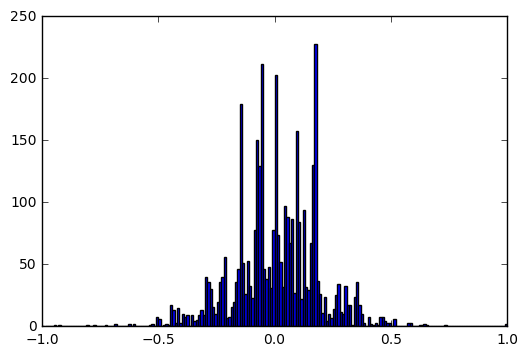

In [56]:
### Plot data
plt.hist(df['steering'],bins=200, range=(-1,1));

In [57]:
### Pre-Process
img_cols = 120
img_rows = 60

def data_trans(image, label):
    trans_factor = 50*np.random.uniform() - 25 # Parameters set based on original image dimensions
    trans_matrix = np.float32([[1,0,trans_factor],[0,1,trans_factor]])
    image_trans = cv2.warpAffine(image,trans_matrix,(image.shape[1],image.shape[0]))

    label = label + trans_factor/120
    #print(label)
    
    return image_trans, label
    
    
def preprocess_data(image, label, flag):
    # Crop Image
    image = image[60:140,:]
    
    # Resize
    image = cv2.resize(image, (img_cols, img_rows))
    
    # Translate image and steering angle
    if flag == "TRAIN":
        image, label = data_trans(image, label)
    
    # Normalize
    #image = cv2.normalize(image, None, alpha=-0.5, beta=0.5, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    return image, label

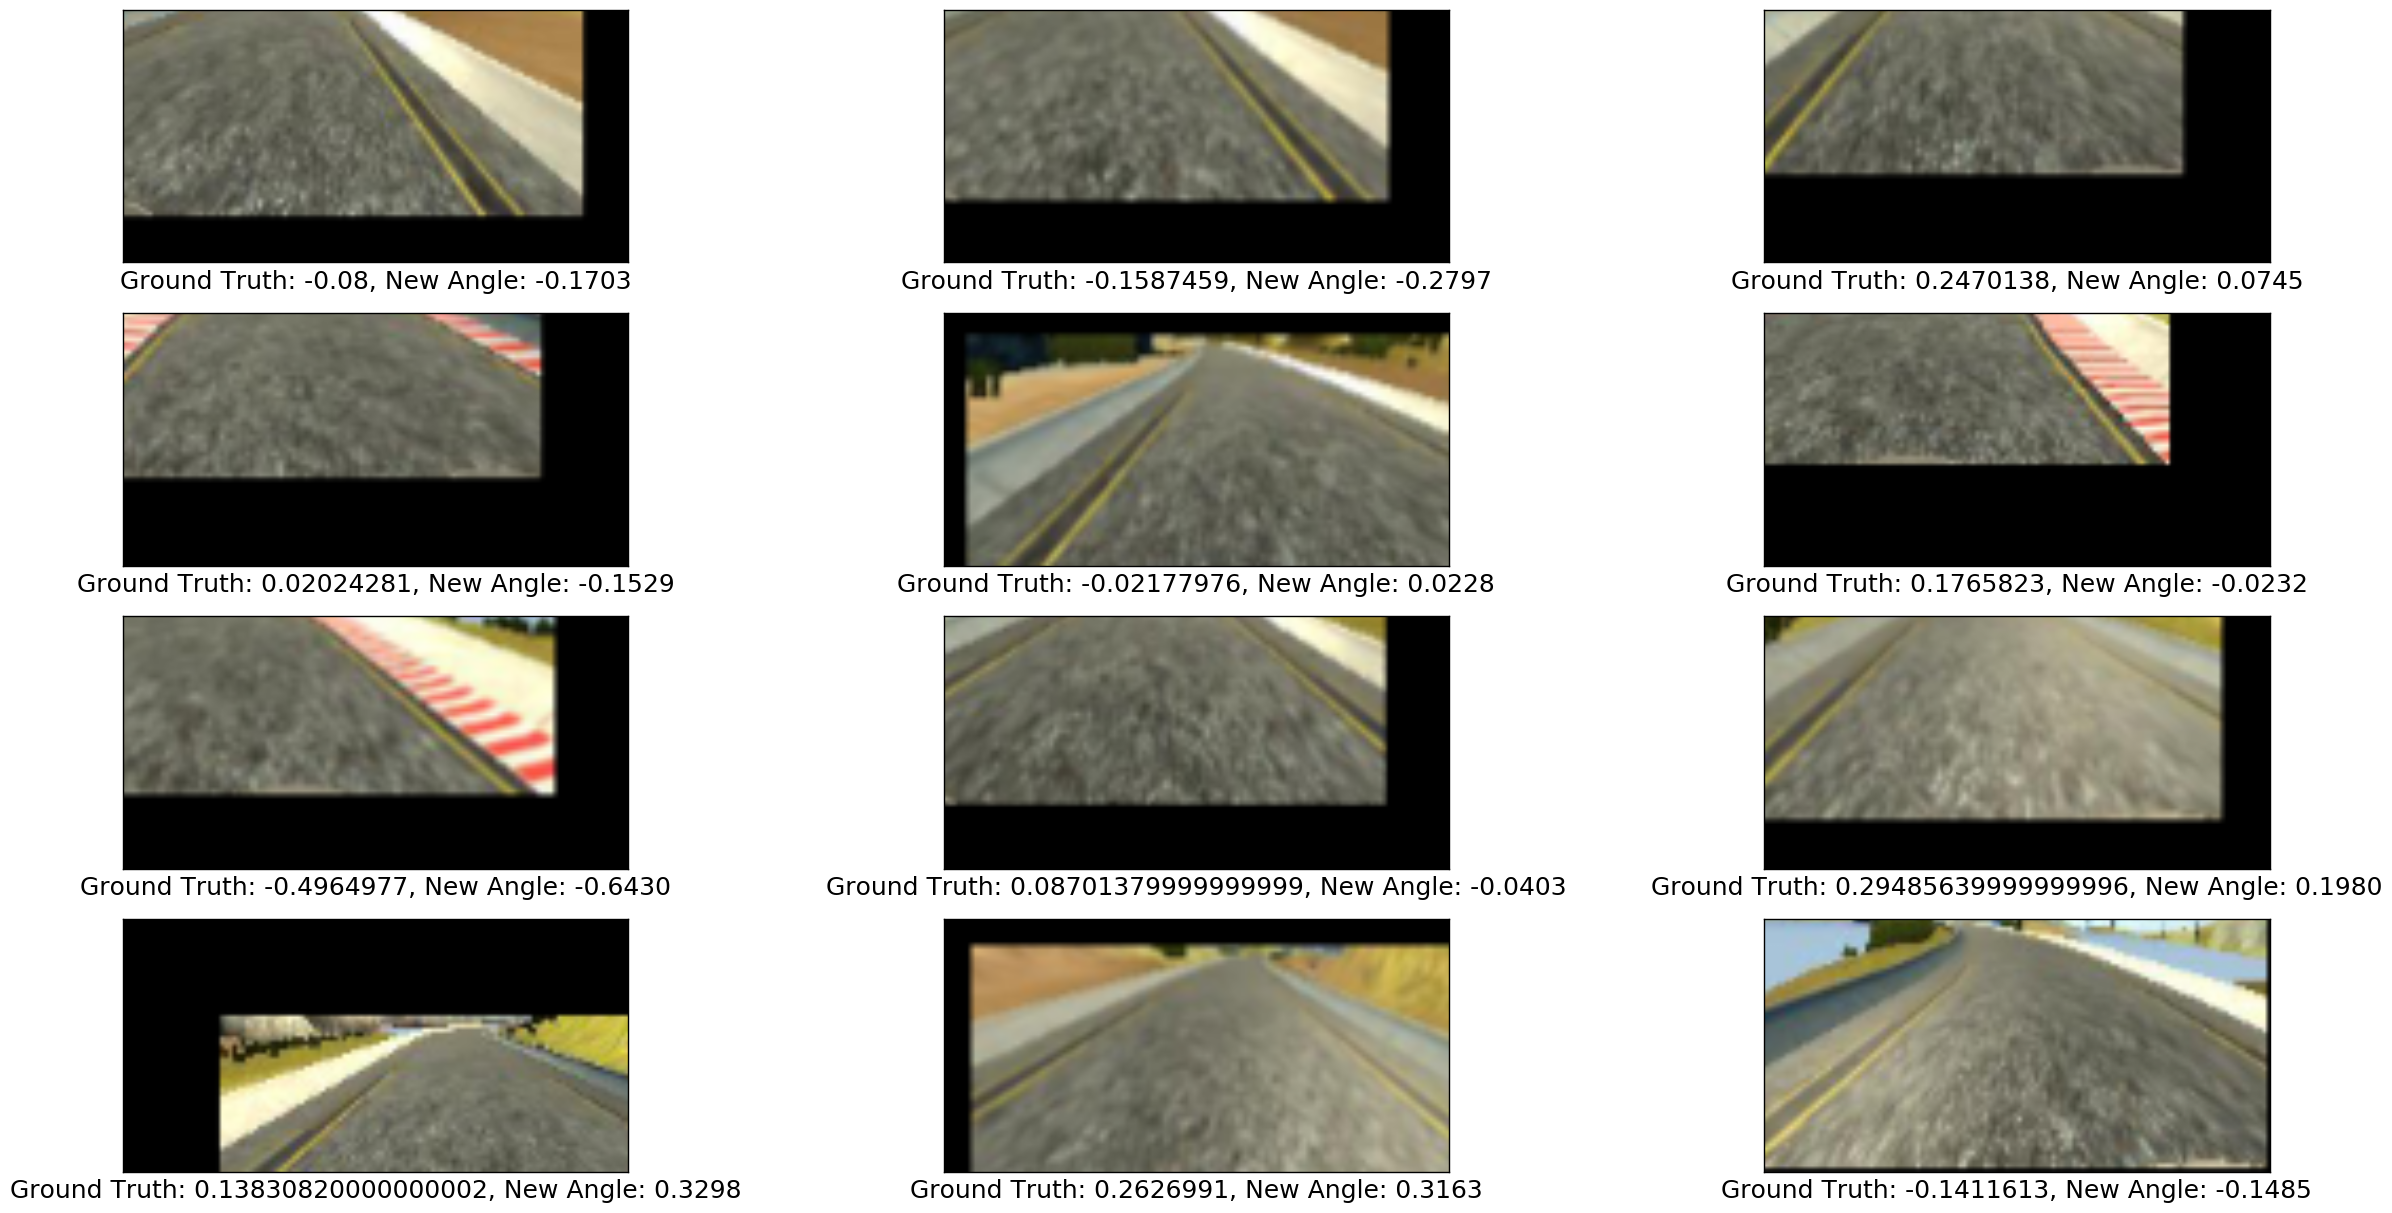

In [58]:
### Plot images
fig = plt.figure(figsize=(30, 15))

for i in range(12):
    image_seq = np.random.randint(1,len(X_train))
    image = mpimg.imread("data/" + X_train[image_seq])
    image, label = preprocess_data(image, y_train[image_seq], "TRAIN")
    
    img = fig.add_subplot(4,3,i+1)
    plt.imshow(image)
    img.set_xlabel("Ground Truth: {0}, New Angle: {1:.4f}".format(y_train[image_seq],label),fontsize=18)
    
    img.set_xticks([])
    img.set_yticks([])

plt.show()


In [4]:
### Helper Functions

def image_generator(csv_features, csv_labels, flag):
    csv_features, csv_labels = shuffle(csv_features, csv_labels)
    p = 1000
    for idx in range(len(csv_features)):
        
        label = csv_labels[idx]
        
        image = mpimg.imread("data/" + csv_features[idx])
        image, label = preprocess_data(image, label, flag)
        ''' 
        if  p < 1020 and flag == "TRAIN":
            mpimg.imsave("image" + str(p),image)
            print(label)
            p += 1
        '''
        yield image, label

epoch_labels = []
def train_data_generator(csv_features, csv_labels, batch_size):
    num_rows = int(len(csv_features))
    ctr = None
    batch_x = np.zeros((batch_size, img_rows, img_cols, 3))
    batch_y = np.zeros(batch_size)
    while True:
        
        for i in range(batch_size):
            
            if ctr is None or ctr >= num_rows:
                print("length of batch: {0}".format(len(batch_x)))
                ctr = 0
                images = image_generator(csv_features, csv_labels, "TRAIN")
            batch_x[i], batch_y[i] = next(images)
            ctr += 1

        yield (batch_x, batch_y)

def valid_data_generator(csv_features, csv_labels, batch_size):
    num_rows = int(len(csv_features))
    ctr = None
    batch_x = np.zeros((batch_size, img_rows, img_cols, 3))
    batch_y = np.zeros(batch_size)
    while True:
        
        for i in range(batch_size):
            
            if ctr is None or ctr >= num_rows:
                print("length of batch: {0}".format(len(batch_x)))
                ctr = 0
                images = image_generator(csv_features, csv_labels, "VALID")
            batch_x[i], batch_y[i] = next(images)
            ctr += 1
        
        yield (batch_x, batch_y)
        
print(X_train.shape)

(13231,)


In [5]:
### Parameters
layer_1_depth = 32
layer_2_depth = 64
layer_3_depth = 128
filter_size_1 = 5
filter_size_2 = 3
num_neurons_1 = 512
num_neurons_2 = 128
epochs = 3
batch_size = 64
samples_per_epoch = X_train.shape[0]

In [6]:
### Model
model = Sequential()
model.add(Convolution2D(layer_1_depth, filter_size_2, filter_size_2, border_mode = 'valid', subsample = (2,2), input_shape = (img_rows, img_cols, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Convolution2D(layer_2_depth, filter_size_2, filter_size_2, border_mode = 'valid', subsample = (1,1)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Convolution2D(layer_3_depth, filter_size_2, filter_size_2, border_mode = 'valid', subsample = (1,1)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(num_neurons_1))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(num_neurons_2))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(32))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(1))

model.summary()

model.compile(loss='mse',
              optimizer=Adam(lr = 0.0001),
              metrics=['mean_absolute_error'])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 29, 59, 32)    896         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 29, 59, 32)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 14, 29, 32)    0           activation_1[0][0]               
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 14, 29, 32)    0           maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [7]:
### Save Model
with open('model.json', 'w') as f:
	json.dump(model.to_json(), f)                                           

history = model.fit_generator(train_data_generator(X_train, y_train, batch_size),
                              samples_per_epoch=samples_per_epoch,
                              nb_epoch = epochs,
                              verbose = 1,
                              validation_data = valid_data_generator(X_val, y_val, batch_size),
                              nb_val_samples=X_val.shape[0])


### Save weights
model.save_weights('model.h5')

Epoch 1/3length of batch: 64

13184/13231 [============================>.] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.2023length of batch: 64


/opt/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:1470: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


length of batch: 64
13248/13231 [==============================] - 32s - loss: 0.0619 - mean_absolute_error: 0.2021 - val_loss: 0.0445 - val_mean_absolute_error: 0.1678
Epoch 2/3
13248/13231 [==============================] - 28s - loss: 0.0444 - mean_absolute_error: 0.1671 - val_loss: 0.0337 - val_mean_absolute_error: 0.1428
Epoch 3/3
13248/13231 [==============================] - 28s - loss: 0.0400 - mean_absolute_error: 0.1584 - val_loss: 0.0316 - val_mean_absolute_error: 0.1377
